<a href="https://colab.research.google.com/github/pelinbalci/Tinyml_Occupancy_Detection/blob/main/Occupancy_TFLite_vs_NeutonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this colab, I will use the Occupancy Detection Data Set to generate TensorFlow and TensorFlow Lite models. The  Then I upload the datasets to Neuton.AI platform and compare the results. 

**The problem is:**

Recognize whether someone is in the room or not based on measurements of temperature, humidity, light, and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

**Features and Target**
- Temperature Humidity
- Light
- CO2
- Humidity Ratio
- Occupancy – 0 - not occupied; 1 - occupied status.

**Content of the Notebook:**

- Data Analysis: read and analyze the dataset.
- Prepare Data: prepare & normalize data to training phase 
- Tensor Flow Model: Train data with tensorflow model
- TensorFlow Lite Model Explanation: Explain each step for tflite model
- Converted model with no quantization
- Convert using dynamic range quantization
- Convert using float fallback quantization
- Neuton AI Results
- Summary: Compare the tensorflow model with tensorflow lite models

**References:**

Neuton AI Platform: https://neuton.ai/

[1] https://colab.research.google.com/github/tinyMLx/colabs/blob/master/3-3-12-QAT.ipynb

[2] https://www.tensorflow.org/lite/performance/post_training_integer_quant

[3] https://studymachinelearning.com/model-quantization-methods-in-tensorflow-lite/

[4] https://towardsdatascience.com/tensorflow-on-arduino-b336f08fa0e9

[5] https://www.youtube.com/watch?v=HXzz87WVm6c

Data: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+# 

The dataset is preprocessed earlier: The DateTime column was deleted before training. Then the original dataset was divided into train and test sets before training.

# Data Analysis

Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_set = pd.read_csv('/content/occupancy_detection_training.csv')
data_set_test = pd.read_csv('/content/occupancy_detection_valid.csv')

In [ ]:
data_set.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,22.600000,17.166667,140.666667,446.000000,0.002904,0
1,19.633333,30.100000,226.000000,423.000000,0.004253,0
2,21.500000,20.840000,528.500000,832.500000,0.003299,1
3,22.200000,21.290000,528.666667,895.333333,0.003518,1
4,22.100000,38.200000,433.000000,1880.000000,0.006303,1


In [ ]:
data_set_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,20.29,26.175000,60.75,417.750000,0.003850,0
1,22.10,37.817500,426.00,1801.750000,0.006239,1
2,19.23,30.533333,24.00,435.000000,0.004207,0
3,22.29,26.100000,112.75,898.500000,0.004343,0
4,21.50,33.290000,471.00,1255.333333,0.005286,1


In [ ]:
print('training:', data_set.shape)
print('test:', data_set_test.shape)

training: (2215, 6)
test: (554, 6)


In [ ]:
print(data_set.isnull().sum())

print(data_set_test.isnull().sum())


Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64


In [ ]:
print(data_set.Occupancy.value_counts())

0    1149
1    1066
Name: Occupancy, dtype: int64


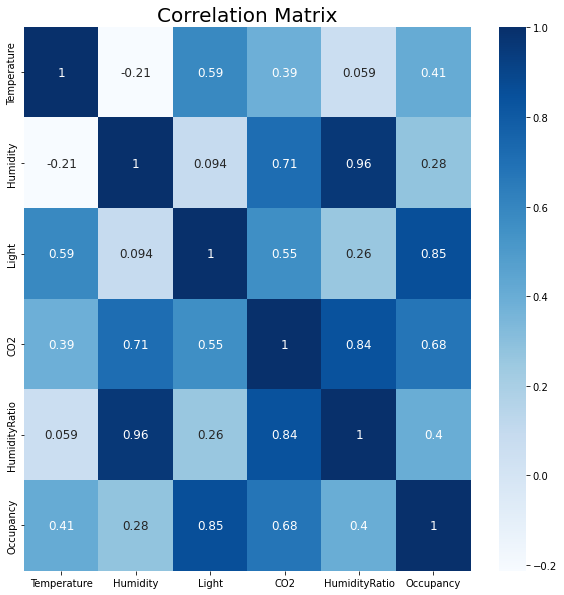

In [ ]:
# Correlation Matrix
correlation_matrix = data_set.corr()

# plot correlation matrix
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix",fontsize=20)
sns.heatmap(correlation_matrix, annot= True, cmap="Blues", annot_kws={'size':12})
plt.show()

# Prepare Data

In [ ]:
from sklearn.preprocessing import StandardScaler

Create train set features & labels

In [ ]:
data = data_set.drop('Occupancy',axis=1)
labels = data_set[["Occupancy"]]

data_test = data_set_test.drop('Occupancy',axis=1)
labels_test = data_set_test[["Occupancy"]]

train_data_ = np.array(data)
train_labels = np.array(labels)
test_data_ = np.array(data_test)
test_labels = np.array(labels_test)

print('Train data shape: {}, train labels shape: {}'.format(train_data_.shape, train_labels.shape))
print('Test data shape: {}, test labels shape: {}'.format(test_data_.shape, test_labels.shape))

Train data shape: (2215, 5), train labels shape: (2215, 1)
Test data shape: (554, 5), test labels shape: (554, 1)


Scale the Data

In [ ]:
scale = StandardScaler()
scale.fit(train_data_)

train_data = scale.transform(train_data_)
test_data = scale.transform(test_data_)

In [ ]:
train_data

array([[ 1.10391568, -1.432334  , -0.67742672, -0.8983183 , -1.21584681],
       [-1.73766119,  0.70109186, -0.26955001, -0.95220737,  0.17930207],
       [ 0.05029729, -0.82639707,  1.17634106,  0.00725247, -0.80753074],
       ...,
       [-0.15084804, -0.76701305,  0.8441446 , -0.00446255, -0.79289515],
       [ 0.57710648, -1.30394355, -1.04865826, -0.9041758 , -1.18284387],
       [ 1.48704964, -1.48896876, -0.4464028 , -0.90534731, -1.20360973]])

In [ ]:
train_labels

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

# Tensor Flow Model

In [ ]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
tf.random.set_seed(15687)

In [ ]:
! pip install -q tensorflow-model-optimization

I will collect the results in dict_summary.

In [ ]:
dict_summary = {}

Load data, build, compile and fit TensorFlow model

I'm using the default learning rate: 0.001 If you want to change the learning rate, use this code: 

    tf.keras.optimizers.Adam(learning_rate=0.1)

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
# Define the model architecture.
model = keras.Sequential([
      keras.layers.Dense(8, activation='relu', input_dim=train_data.shape[1]),
      keras.layers.Dense(1, activation="sigmoid")
])

# Number of parameters
from keras.utils.layer_utils import count_params
trainable_count_tf = count_params(model.trainable_weights)
print('trainable_count: ', trainable_count_tf)

model.summary()

# Train the occupancy data
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=10, validation_split=0.1)

_, baseline_model_accuracy = model.evaluate(
    test_data, test_labels, verbose=0)

print(baseline_model_accuracy)

trainable_count:  57
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 1s 5ms/step - loss: 0.7775 - accuracy: 0.4360 - val_loss: 0.6887 - val_accuracy: 0.5586
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.5809 - accuracy: 0.7085 - val_loss: 0.5310 - val_accuracy: 0.7117
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.8018 - val_loss: 0.4249 - val_accuracy: 0.8378
Epoch 4/10
63/6

In [ ]:
# Define the model architecture.
model2 = keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_dim=train_data.shape[1]),
      keras.layers.Dense(32),
      keras.layers.Dense(32),
      keras.layers.Dense(1, activation="sigmoid")
])

# Number of parameters
trainable_count_tf2 = count_params(model2.trainable_weights)
print('trainable_count: ', trainable_count_tf2)

model2.summary()

# Train the occupancy data
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.fit(train_data, train_labels, epochs=10, validation_split=0.1)

_, baseline_model_accuracy2 = model2.evaluate(
    test_data, test_labels, verbose=0)

print(baseline_model_accuracy2)

trainable_count:  3553
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                384       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 1s 6ms/step - loss: 0.2759 - accuracy: 0.9282 - val_loss: 0.1069 - val_accuracy: 0.9775
Epoch 2/10
63/63 [===

## How to save model & calculate size?

You can save the model by model.save() or tf.saved_model.save(model, saved_model_path). 


You can get the file size by: os.path.getsize  and it gives you bytes. If you want to get megabytes you need to divide it to 2^20 which gives you ~1M

In [ ]:
# save model - first way
model.save('model.h5')

# save model - second way
saved_model_path = 'saved_model/1'
tf.saved_model.save(model, saved_model_path)

# Get file size in bytes for a given model
TF_model_size = os.path.getsize('model.h5') /float(2**10)
print('TF_model_size in KB', TF_model_size)

dict_summary['TensorFlow Model'] = {}
dict_summary['TensorFlow Model']['Parameters'] = trainable_count_tf
dict_summary['TensorFlow Model']['Accuracy'] = baseline_model_accuracy
dict_summary['TensorFlow Model']['Size_kb'] = TF_model_size

INFO:tensorflow:Assets written to: saved_model/1/assets
TF_model_size in KB 25.75


In [ ]:
# save model - first way
model2.save('model2.h5')

# save model - second way
saved_model_path2 = 'saved_model/2'
tf.saved_model.save(model2, saved_model_path2)

# Get file size in bytes for a given model
TF_model_size2 = os.path.getsize('model2.h5') /float(2**10)
print('TF_model_size2 in KB', TF_model_size2)

dict_summary['TensorFlow Model_2'] = {}
dict_summary['TensorFlow Model_2']['Parameters'] = trainable_count_tf2
dict_summary['TensorFlow Model_2']['Accuracy'] = baseline_model_accuracy2
dict_summary['TensorFlow Model_2']['Size_kb'] = TF_model_size2

INFO:tensorflow:Assets written to: saved_model/2/assets
TF_model_size2 in KB 79.6015625


# TensorFlow Lite Model Explanation



## How can we convert model?
There are 3 types of conversion:
- from saved model 
- from keras model
- from concrete functions

**from saved model:**

In [ ]:
converter_1 = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model_1 = converter_1.convert()

**from keras model:**

In [ ]:
converter_ = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_ = converter_.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3wku4as7/assets


INFO:tensorflow:Assets written to: /tmp/tmp3wku4as7/assets


In [ ]:
loaded_model = tf.keras.models.load_model('model.h5')
converter_2 = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model_2 = converter_2.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1ti5fsf8/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ti5fsf8/assets


## How can we save tflite model?

Define the path then, use write_bytes to save the tflite model.

In [ ]:
tflite_model_file = pathlib.Path("/tmp/saved_tflitemodel.tflite")
print(tflite_model_file)
tflite_model_file.write_bytes(tflite_model_1)

/tmp/saved_tflitemodel.tflite


1672

Second way: 

In [ ]:
open('saved_tflitemodel2.tflite', "wb").write(tflite_model_1)

1672

## How can we evaluate the results and make predictions?

The evaluation is very simple in terms of tensorflow models. Simply, the evaluation is completed with model.evaluate() and you can use model.predict() for prediction. However, making evaluation for tensorflowlite model is a bit complicated. 

The full code for predicting a sample test data is below:

In [ ]:
# Load TFLite Model and Allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model_1)
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Take a test_data to predict
test_data_0 = test_data[0]
test_label_0 = test_labels[0]

# Point the data to be used for testing and run the interpreter
trial_test_data = np.expand_dims(test_data_0, axis=0).astype(input_details[0]["dtype"])
interpreter.set_tensor(input_details[0]['index'], trial_test_data)

# Run inference.
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

predicted_label = 0 if output <0.5 else 1
print(predicted_label)

print(test_label_0)

[[0.02886067]]
0
[0]


Let's look at the details. 

- At first, take a sample data:

In [ ]:
test_data_0 = test_data[0]
test_label_0 = test_labels[0]

print('dtype {}, shape{}'.format(test_data_0.dtype, test_data_0.shape))

dtype float64, shape(5,)


- Instantiate the interpreter

In [ ]:
# Load TFLite Model and Allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model_1)

# Load TFLite Model with path
tflite_model_file_dir = '/tmp/saved_tflitemodel.tflite'                
interpreter = tf.lite.Interpreter(model_path=tflite_model_file_dir)

# Allocate tensors
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

- What information does input_details store?

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_dense_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([-1,  5], dtype=int32),
  'sparsity_parameters': {}}]

- The size of the data that interpreter expects: [1,5]

Now we need to expand the dimension of test_data to meet the expected shape:

In [ ]:
trial_test_data = np.expand_dims(test_data_0, axis=0).astype(input_details[0]["dtype"])
print('dtype {}, shape{}'.format(trial_test_data.dtype, trial_test_data.shape))

dtype float32, shape(1, 5)


- What if I don't check the dtype and shape?

In [ ]:
# interpreter.set_tensor(input_details[0]['index'], test_data_0)

"""
ValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_dense_18_input:0 
"""

'\nValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_dense_18_input:0 \n'

In [ ]:
# interpreter.set_tensor(input_details[0]['index'], test_data_0.astype(input_details[0]["dtype"]))

"""
ValueError: Cannot set tensor: Dimension mismatch. Got 1 but expected 2 for input 0.
"""

'\nValueError: Cannot set tensor: Dimension mismatch. Got 1 but expected 2 for input 0.\n'

- Next, we set the tensor for the trial test data. And then invoke the interpreter, it is like model.predict().

In [ ]:
# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], trial_test_data)

# Run inference.
interpreter.invoke()

In [ ]:
# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

predicted_label = 0 if output <0.5 else 1
print(predicted_label)

print(test_label_0)

[[0.02886067]]
0
[0]


# Converted model with no quantization

It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data. [1]

In [ ]:
# Create Float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(float_tflite_model)

#Evaluate results with model
interpreter_1 = tf.lite.Interpreter(model_content=float_tflite_model)

input_details = interpreter_1.get_input_details()
output_details = interpreter_1.get_output_details()

interpreter_1.resize_tensor_input(input_details[0]['index'], test_data.shape)
interpreter_1.resize_tensor_input(output_details[0]['index'], test_labels.shape)
interpreter_1.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# test_data_np = np.expand_dims(test_data, axis=0).astype(input_details[0]["dtype"])
test_data_np = np.array(test_data, dtype=np.float32)
print(test_data_np.shape)
print(input_details[0]['shape'])
interpreter_1.set_tensor(input_details[0]['index'], test_data_np)

# Run inference.
interpreter_1.invoke()

# Post-processing: remove batch dimension and find the digit with highest
# probability.
output = interpreter_1.get_tensor(output_details[0]['index'])
predicted_label =np.where(output<0.5, 0, 1)   # np.array(0 if output <0.5 else 1)
print(predicted_label.shape, test_labels.shape)

print('\n')
# Compare prediction results with ground truth labels to calculate accuracy.
acc = (np.array(predicted_label) == test_labels).mean()
print('Accuracy:', acc)

# Measure sizes of models.
tflite_model_file_dir = '/tmp/model1.tflite'    
no_quant_size = os.path.getsize(tflite_model_file_dir) / float(2**10)
print("model size in Mb:", no_quant_size)

dict_summary['TFLite_no_quantization'] = {}
dict_summary['TFLite_no_quantization']['Parameters'] = '-'
dict_summary['TFLite_no_quantization']['Accuracy'] = acc
dict_summary['TFLite_no_quantization']['Size_kb'] = no_quant_size

INFO:tensorflow:Assets written to: /tmp/tmponw92ywd/assets


INFO:tensorflow:Assets written to: /tmp/tmponw92ywd/assets


(554, 5)
[1 5]
(554, 1) (554, 1)


Accuracy: 0.9747292418772563
model size in Mb: 1.6328125


# Convert using dynamic range quantization

Now let's enable the default optimizations flag to quantize all fixed parameters (such as weights).

The model is now a bit smaller with quantized weights, but other variable data is still in float format. [1]

In [ ]:
# Create TFLite model
converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model) 
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_dynamic = converter_dynamic.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model2.tflite'
tflite_model_file.write_bytes(tflite_model_dynamic)

#Evaluate results with model
interpreter_2 = tf.lite.Interpreter(model_content=tflite_model_dynamic)
interpreter_2.allocate_tensors()

interpreter_2.resize_tensor_input(input_details[0]['index'], test_data.shape)
interpreter_2.resize_tensor_input(output_details[0]['index'], test_labels.shape)
interpreter_2.allocate_tensors()

input_details = interpreter_2.get_input_details()
output_details = interpreter_2.get_output_details()

# test_data_np = np.expand_dims(test_data, axis=0).astype(input_details[0]["dtype"])
test_data_np = np.array(test_data, dtype=np.float32)
print(test_data_np.shape)
print(input_details[0]['shape'])
interpreter_2.set_tensor(input_details[0]['index'], test_data_np)

# Run inference.
interpreter_2.invoke()

# Post-processing: remove batch dimension and find the digit with highest
# probability.
output = interpreter_2.get_tensor(output_details[0]['index'])
predicted_label =np.where(output<0.5, 0, 1)   # np.array(0 if output <0.5 else 1)
print(predicted_label.shape, test_labels.shape)

print('\n')
# Compare prediction results with ground truth labels to calculate accuracy.
test_accuracy_2 = (np.array(predicted_label) == test_labels).mean()
print('Accuracy:', test_accuracy_2)

# Measure sizes of models.
tflite_model_file_dir = '/tmp/model2.tflite'   
dynamic_range_quant_size = os.path.getsize(tflite_model_file_dir) / float(2**10)
print("model in Mb:", dynamic_range_quant_size)


dict_summary['Dynamic_range_quantization'] = {}
dict_summary['Dynamic_range_quantization']['Parameters'] = '-'
dict_summary['Dynamic_range_quantization']['Accuracy'] = test_accuracy_2
dict_summary['Dynamic_range_quantization']['Size_kb'] = dynamic_range_quant_size

INFO:tensorflow:Assets written to: /tmp/tmp8r1nd0f8/assets


INFO:tensorflow:Assets written to: /tmp/tmp8r1nd0f8/assets


(554, 5)
[554   5]
(554, 1) (554, 1)


Accuracy: 0.9747292418772563
model in Mb: 1.734375


# Convert using float fallback quantization

"To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a **RepresentativeDataset**. 

This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) 

To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices." [1]

Ref: https://stackoverflow.com/questions/59855961/converting-keras-model-with-tfliteconverter-to-quantized-tflite-version-results

In [ ]:
def representative_data_gen():
  for i in range(100):
    yield [test_data[i].astype(np.float32)]

# Convert model
converter_rep = tf.lite.TFLiteConverter.from_keras_model(model)
converter_rep.optimizations = [tf.lite.Optimize.DEFAULT]
converter_rep.representative_dataset = representative_data_gen
tflite_model_quant_rep = converter_rep.convert()

# Write tflite model to path
tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model3.tflite' 
tflite_model_file.write_bytes(tflite_model_quant_rep)

#Evaluate results with model
interpreter_3 = tf.lite.Interpreter(model_content=tflite_model_quant_rep)
interpreter_3.allocate_tensors()

interpreter_3.resize_tensor_input(input_details[0]['index'], test_data.shape)
interpreter_3.resize_tensor_input(output_details[0]['index'], test_labels.shape)
interpreter_3.allocate_tensors()

input_details = interpreter_3.get_input_details()
output_details = interpreter_3.get_output_details()

# test_data_np = np.expand_dims(test_data, axis=0).astype(input_details[0]["dtype"])
test_data_np = np.array(test_data, dtype=np.float32)
print(test_data_np.shape)
print(input_details[0]['shape'])
interpreter_3.set_tensor(input_details[0]['index'], test_data_np)

# Run inference.
interpreter_3.invoke()

# Post-processing: remove batch dimension and find the digit with highest
# probability.
output = interpreter_3.get_tensor(output_details[0]['index'])
predicted_label =np.where(output<0.5, 0, 1)   # np.array(0 if output <0.5 else 1)
print(predicted_label.shape, test_labels.shape)

print('\n')
# Compare prediction results with ground truth labels to calculate accuracy.
test_accuracy_3 = (np.array(predicted_label) == test_labels).mean()
print('Accuracy:', test_accuracy_3)


# Measure sizes of models.
tflite_models_dir = tflite_models_dir/'model3.tflite'
float_fallback_quant_size = os.path.getsize(tflite_models_dir) / float(2**10)
print("model in Kb:", float_fallback_quant_size)


dict_summary['Representative_Dataset_Float_Fallback'] = {}
dict_summary['Representative_Dataset_Float_Fallback']['Parameters'] = '-'
dict_summary['Representative_Dataset_Float_Fallback']['Accuracy'] = test_accuracy_3
dict_summary['Representative_Dataset_Float_Fallback']['Size_kb'] = float_fallback_quant_size

INFO:tensorflow:Assets written to: /tmp/tmprokpts3t/assets


INFO:tensorflow:Assets written to: /tmp/tmprokpts3t/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


(554, 5)
[554   5]
(554, 1) (554, 1)


Accuracy: 0.9747292418772563
model in Kb: 2.0859375


# Neuton AI

- Accuracy 0.981279
- Model Size Kb: 0.14
- Coefficients: 60

In [ ]:
dict_summary['Neuton_AI'] = {}
dict_summary['Neuton_AI']['Parameters'] =  60
dict_summary['Neuton_AI']['Accuracy'] =  0.981279
dict_summary['Neuton_AI']['Size_kb'] = 0.14

# Summary

Below, accuracies and sizes of TensorFlow model and Tensorflow Lite Models and Neuton AI results are prenseted. As you can see, the accuracy doesn't change with quantization in TFLite models. 

The parameters of Tensowflow Model are almost the same as NeutonAI model, but the NeutonAI gives better results in terms of accuracy. Moreover the size of model is **ten times** smaller than TFLite models. 


In [ ]:
import pandas as pd
summary = pd.DataFrame.from_dict(dict_summary).T.reset_index()
summary.rename(columns={'index': 'Model'}, inplace=True)
summary.Size_kb = summary.Size_kb.astype(float)
summary

,Model,Parameters,Accuracy,Size_kb
0,TensorFlow Model,57.0,0.974729,25.750000
1,TensorFlow Model_2,3553.0,0.990975,79.601562
2,TFLite_no_quantization,-,0.974729,1.632812
3,Dynamic_range_quantization,-,0.974729,1.734375
4,Representative_Dataset_Float_Fallback,-,0.974729,2.085938
5,Neuton_AI,60.0,0.981279,0.140000


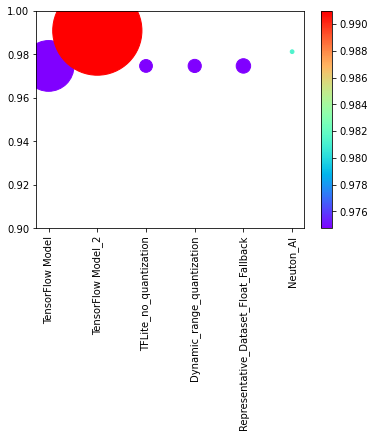

In [ ]:
plt.scatter(summary.Model, summary.Accuracy,  c=summary.Accuracy, cmap='rainbow', s=summary.Size_kb*100)
plt.ylim(ymax = 1, ymin = 0.9)
plt.xticks(rotation = 90)
plt.colorbar()
plt.show()

# Encode the Model in an Arduino Header File

In [ ]:
open('model3.tflite', "wb").write(tflite_model_quant_rep)

!apt-get update && apt-get -qq install xxd
!xxd -i 'model3.tflite' > model.h
!cat model.h

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 